## 在线测评

给定：**女性电子商务服装评论数据集**数据集，请：

    1、对数据进行探查、查看缺失值并处理
    2、对评论的消极/积极数量进行可视化展示
    3、利用 wordcloud库 构建词云

## 在线测评示例代码

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import nltk.classify.util
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.classify import NaiveBayesClassifier
import numpy as np
import re
import string
import nltk
%matplotlib inline

### 数据探查

In [2]:
df = pd.read_csv(r'./Womens Clothing E-Commerce Reviews.csv')
print(len(df))  # 评论条数
df.head()

23486


,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 保留本例题需要用到的字段

In [3]:
review = df[['Unnamed: 0', 'Age', 'Title', 'Review Text', 'Rating']]
review.head()

,Unnamed: 0,Age,Title,Review Text,Rating
0,0,33,NaN,Absolutely wonderful - silky and sexy and comf...,4
1,1,34,NaN,Love this dress! it's sooo pretty. i happene...,5
2,2,60,Some major design flaws,I had such high hopes for this dress and reall...,3
3,3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5
4,4,47,Flattering shirt,This shirt is very flattering to all due to th...,5


### 缺失值查看

In [4]:
review.isnull().sum()

Unnamed: 0        0
Age               0
Title          3810
Review Text     845
Rating            0
dtype: int64

### 缺失值处理
**删除缺失值**

In [5]:
# 去除缺失值
senti= review[review['Title'].notnull()]
senti= review[review['Review Text'].notnull()]
print('去除缺失值后的评论条数 :', len(senti))
senti.head()

去除缺失值后的评论条数 : 22641


,Unnamed: 0,Age,Title,Review Text,Rating
0,0,33,NaN,Absolutely wonderful - silky and sexy and comf...,4
1,1,34,NaN,Love this dress! it's sooo pretty. i happene...,5
2,2,60,Some major design flaws,I had such high hopes for this dress and reall...,3
3,3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5
4,4,47,Flattering shirt,This shirt is very flattering to all due to th...,5


### 定义积极(pos)、消极(neg)

In [6]:
senti['senti'] = senti.loc[:,('Rating')]>=4.0
senti['senti'] = senti['senti'].replace([True , False] , ["pos" , "neg"])

<ipython-input-6-c205eec607f2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  senti['senti'] = senti.loc[:,('Rating')]>=4.0
<ipython-input-6-c205eec607f2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  senti['senti'] = senti['senti'].replace([True , False] , ["pos" , "neg"])


In [7]:
senti.head()

,Unnamed: 0,Age,Title,Review Text,Rating,senti
0,0,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,pos
1,1,34,NaN,Love this dress! it's sooo pretty. i happene...,5,pos
2,2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,neg
3,3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,pos
4,4,47,Flattering shirt,This shirt is very flattering to all due to th...,5,pos


<AxesSubplot:>

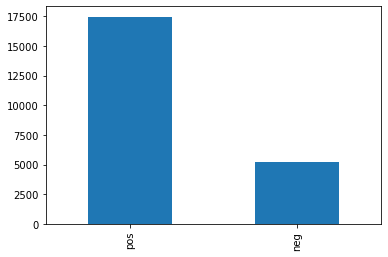

In [8]:
### 可视化展示处理后的 积极/消极 数据
senti["senti"].value_counts().plot.bar()

In [9]:
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
import numpy as np
import re
import string
import nltk

### 将评价内容的大写转为小写

In [10]:
cleanup_re = re.compile('[^a-z]+')
def cleanup(sentence):
    sentence = str(sentence)
    sentence = sentence.lower()
    sentence = cleanup_re.sub(' ', sentence).strip()
    return sentence
senti['Summary_Clean'] = senti['Review Text'].apply(cleanup)

<ipython-input-10-60fa5cdb8add>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  senti['Summary_Clean'] = senti['Review Text'].apply(cleanup)


### 取senti、Summary_Clean

In [11]:
split = senti[["Summary_Clean" , "senti"]]
split.head()

,Summary_Clean,senti
0,absolutely wonderful silky and sexy and comfor...,pos
1,love this dress it s sooo pretty i happened to...,pos
2,i had such high hopes for this dress and reall...,neg
3,i love love love this jumpsuit it s fun flirty...,pos
4,this shirt is very flattering to all due to th...,pos


使用 **split.sample()**将 split 中 80%的数据集做为训练集，使用 drop()去除 split 中已经出现在训练集 train 中的数据，剩余数据作为测试集 test。

In [12]:
train=split.sample(frac=0.8,random_state=200)
test=split.drop(train.index)

###  构建词云

In [13]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
mpl.rcParams['font.size']=12 #10 
mpl.rcParams['savefig.dpi']=100 #72 
mpl.rcParams['figure.subplot.bottom']=.1 
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=300,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
        ).generate(str(data))
 
    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()

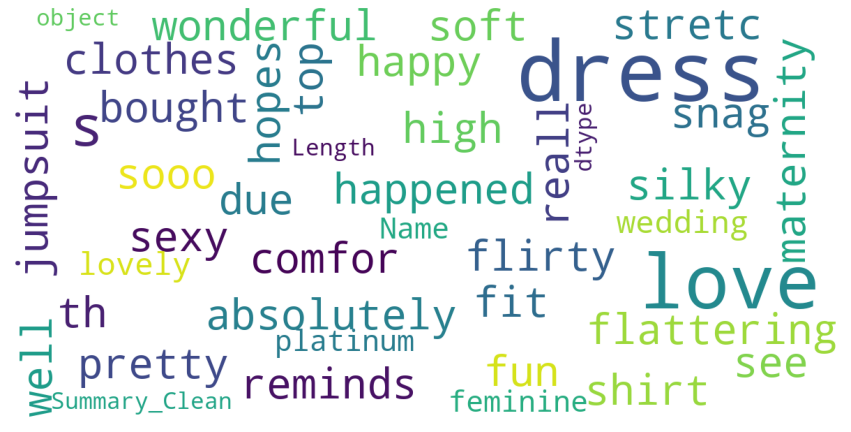

In [14]:
show_wordcloud(senti['Summary_Clean'])